In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from starfish.set import settings

In [3]:
def var_filter(fisher,lcdm,neff_fixed):
    df=fisher.copy()
    if lcdm:
        df=df.drop('w0',axis=0)
        df=df.drop('w0',axis=1)
        df=df.drop('wa',axis=0)
        df=df.drop('wa',axis=1)
    if neff_fixed:
        df=df.drop('N_eff',axis=0)
        df=df.drop('N_eff',axis=1)

    return df

# JPAS ELG + PFS ELG

In [4]:
JPAS_ELG=[]
for redshift in settings.z_JPAS_ELG:
    df=pd.DataFrame(np.loadtxt(f'../data/ELG/J-PAS_{redshift:.1f}.csv',delimiter=','),index=settings.name_JPAS_ELG,columns=settings.name_JPAS_ELG)
    JPAS_ELG.append(var_filter(df,lcdm=False,neff_fixed=True))

In [5]:
PFS_ELG=[]
for redshift in settings.z_PFS_ELG:
    df=pd.DataFrame(np.loadtxt(f'../data/PFS/PFS_{redshift:.1f}.csv',delimiter=','),index=settings.name_PFS_ELG,columns=settings.name_PFS_ELG)
    PFS_ELG.append(var_filter(df,lcdm=False,neff_fixed=True))

In [6]:
JPAS_ELG_valid=[]
for fisher in JPAS_ELG:
    fisher_valid=fisher.copy()
    for index in fisher_valid.index:
        if (fisher_valid.loc[index,:]==0).all():
            fisher_valid=fisher_valid.drop(index,axis=0)
            fisher_valid=fisher_valid.drop(index,axis=1)
    cov=pd.DataFrame(np.linalg.inv(fisher_valid.values),index=fisher_valid.index,columns=fisher_valid.columns)
    JPAS_ELG_valid.append(cov.iloc[:settings.cosmo_num,:settings.cosmo_num])

In [7]:
PFS_ELG_valid=[]
for fisher in PFS_ELG:
    fisher_valid=fisher.copy()
    for index in fisher_valid.index:
        if (fisher_valid.loc[index,:]==0).all():
            fisher_valid=fisher_valid.drop(index,axis=0)
            fisher_valid=fisher_valid.drop(index,axis=1)
    cov=pd.DataFrame(np.linalg.inv(fisher_valid.values),index=fisher_valid.index,columns=fisher_valid.columns)
    PFS_ELG_valid.append(cov.iloc[:settings.cosmo_num,:settings.cosmo_num])

In [8]:
JPAS_ELG_valid_dict=dict(zip(settings.z_JPAS_ELG,JPAS_ELG_valid))
PFS_ELG_valid_dict=dict(zip(settings.z_PFS_ELG,PFS_ELG_valid))

In [9]:
fisher_combined_ELG=[]
for redshift in settings.z:
    if redshift in JPAS_ELG_valid_dict.keys():
        fisher1=np.linalg.inv(JPAS_ELG_valid_dict[redshift].values)
        index=JPAS_ELG_valid_dict[redshift].index
        columns=JPAS_ELG_valid_dict[redshift].columns
    else:
        fisher1=0
    if redshift in PFS_ELG_valid_dict.keys():
        fisher2=np.linalg.inv(PFS_ELG_valid_dict[redshift].values)
        index=PFS_ELG_valid_dict[redshift].index
        columns=PFS_ELG_valid_dict[redshift].columns
    else:
        fisher2=0
    fisher_combined_ELG.append(pd.DataFrame(fisher1+fisher2,index=index,columns=columns))

In [10]:
from getdist import plots
from getdist.gaussian_mixtures import GaussianND

gauss = []
for f in fisher_combined_ELG:
    g = GaussianND(settings.cosmo_value, f, is_inv_cov=True, names=settings.var_exp)
    g.paramNames.names[-3].name = r"$\sum m_{\nu}\;[\mathrm{eV}]$"
    g.paramNames.names[-3].label = ""
    g.names = settings.var_exp
    gauss.append(g)

In [11]:
import seaborn as sns
palette=sns.color_palette('rocket_r',n_colors=len(fisher_combined_ELG))
palette

[(0.96739773, 0.77451297, 0.65057302),
 (0.96298491, 0.6126247, 0.45145074),
 (0.95165009, 0.44224144, 0.30214494),
 (0.90848638, 0.24568473, 0.24598324),
 (0.79085854, 0.10184672, 0.313391),
 (0.63139686, 0.10067417, 0.35664819),
 (0.45809049, 0.12142996, 0.34540024),
 (0.29977678, 0.11356089, 0.29254823),
 (0.14633406, 0.07973393, 0.1986151)]

In [12]:
orders=[r'$\sum m_{\nu}\;[\mathrm{eV}]$',r'$w_0$',r'$w_a$']
m=dict(zip(settings.var_exp,settings.cosmo_value))
err=[]
for f in fisher_combined_ELG:
    cov=np.linalg.inv(f.values)
    err.append(np.sqrt(np.diag(cov)))
err_max=np.sort(np.stack(err,axis=0),axis=0)[-1,:]
lower=settings.cosmo_value-2*err_max
lower[-3]=0
limits=list(zip(lower,settings.cosmo_value+2*err_max))
d=dict(zip(settings.var_exp,limits))

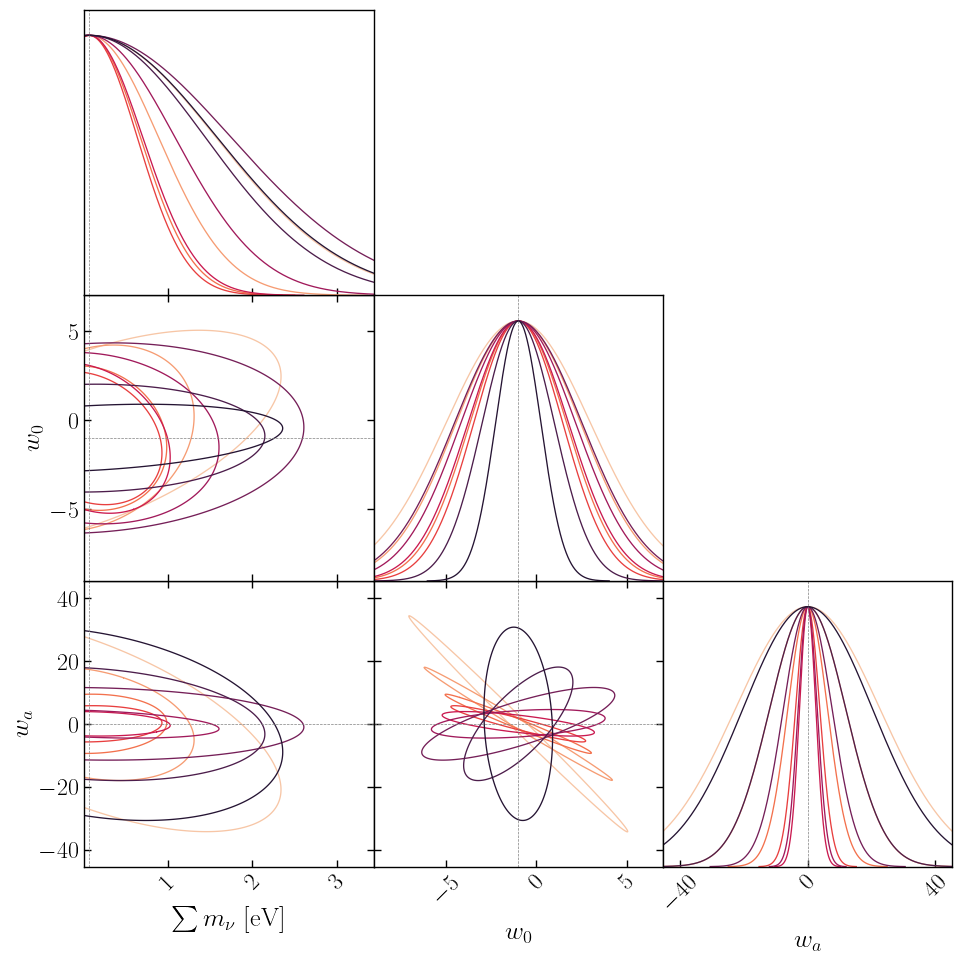

In [13]:
sns.set_context('paper',font_scale=2)
ploter=plots.get_subplot_plotter(width_inch=10,rc_sizes=True)
ploter.settings.tight_layout=True
ploter.settings.axis_tick_x_rotation=45
ploter.settings.figure_legend_frame=False
ploter.settings.num_plot_contours=1
ploter.triangle_plot(
    gauss,
    params=orders,
    param_limits=d,
    filled=False,
    markers=m,
    marker_args={'color':'gray'},
    legend_labels=[],
    contour_colors=palette,
    contour_ls='-',
    legend_loc='upper right')

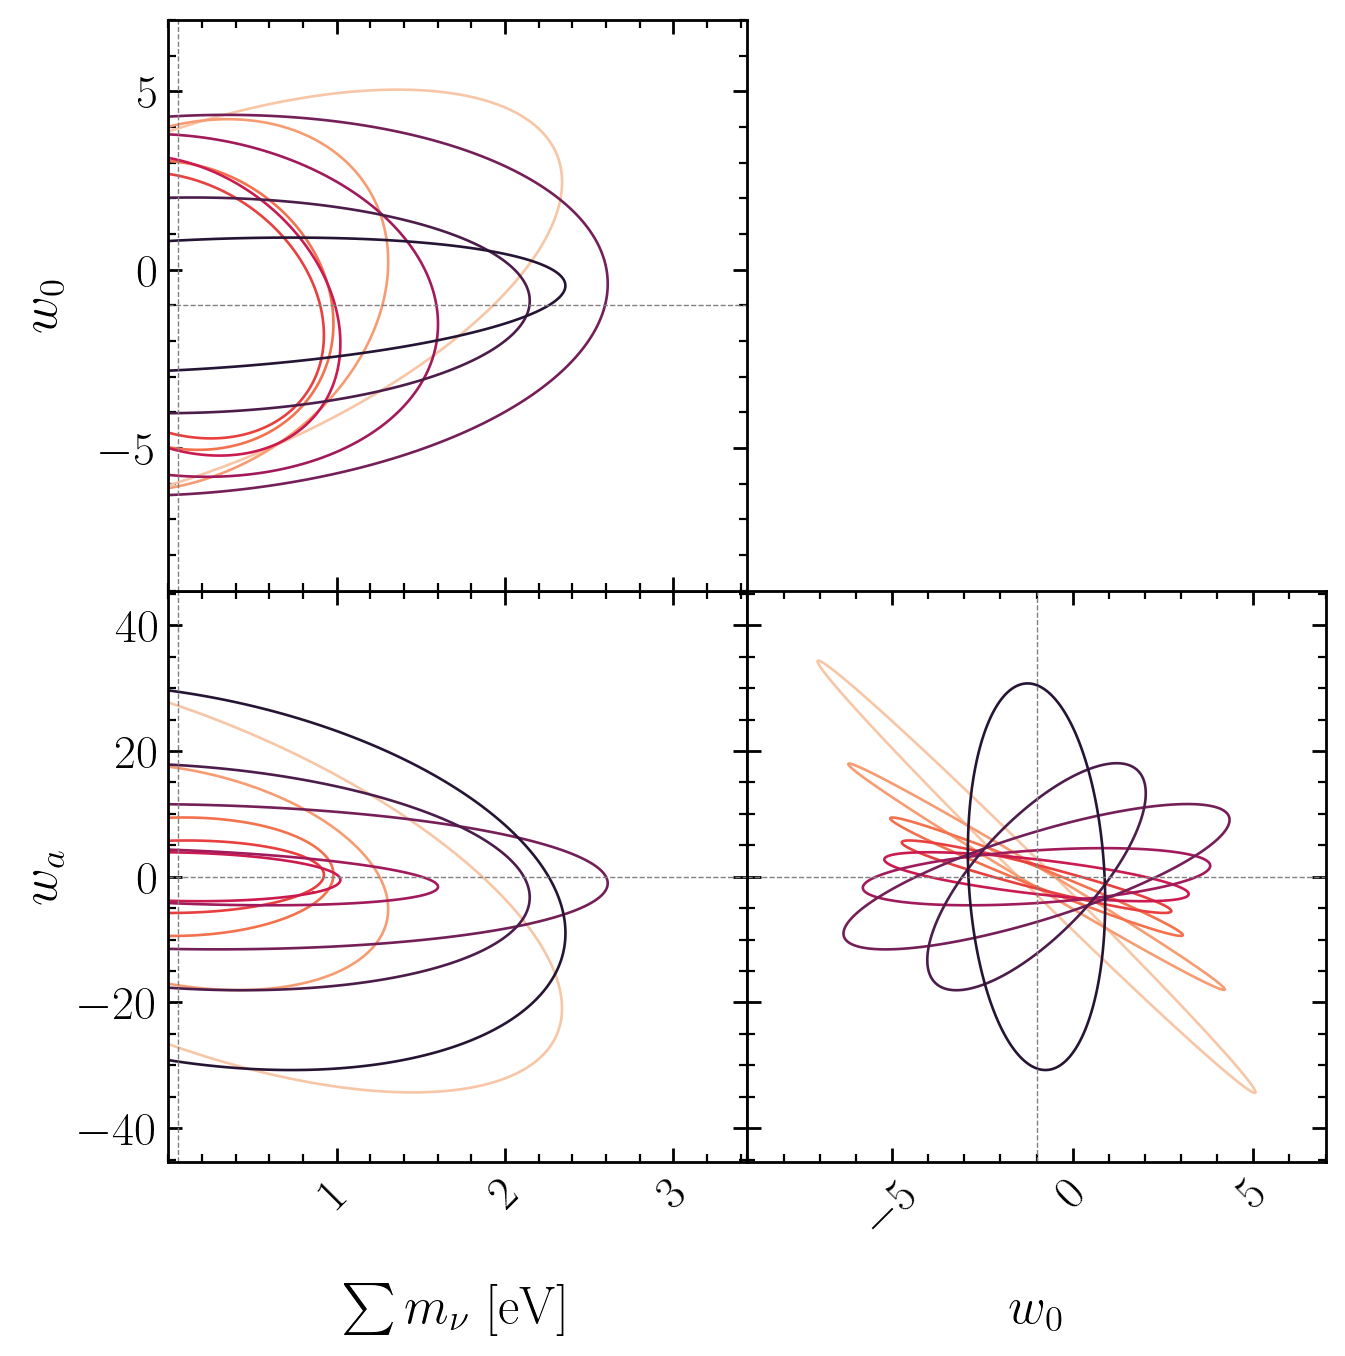

In [14]:
ploter.fig.set_dpi(200)
ploter.fig.align_labels()
for ax in ploter.fig.axes:
    ax.minorticks_on()
    ax.tick_params(which='major',length=5)
    ax.tick_params(which='minor',length=3)
y=len(orders)
axes=[]
start=0
for x in range(len(orders)):
    axes.append(ploter.fig.axes[start:start+y])
    start+=y
    y-=1
for col in axes:
    col[-1].set_visible(False)
ploter.fig.subplots_adjust(wspace=0.,hspace=0.)
ploter.fig

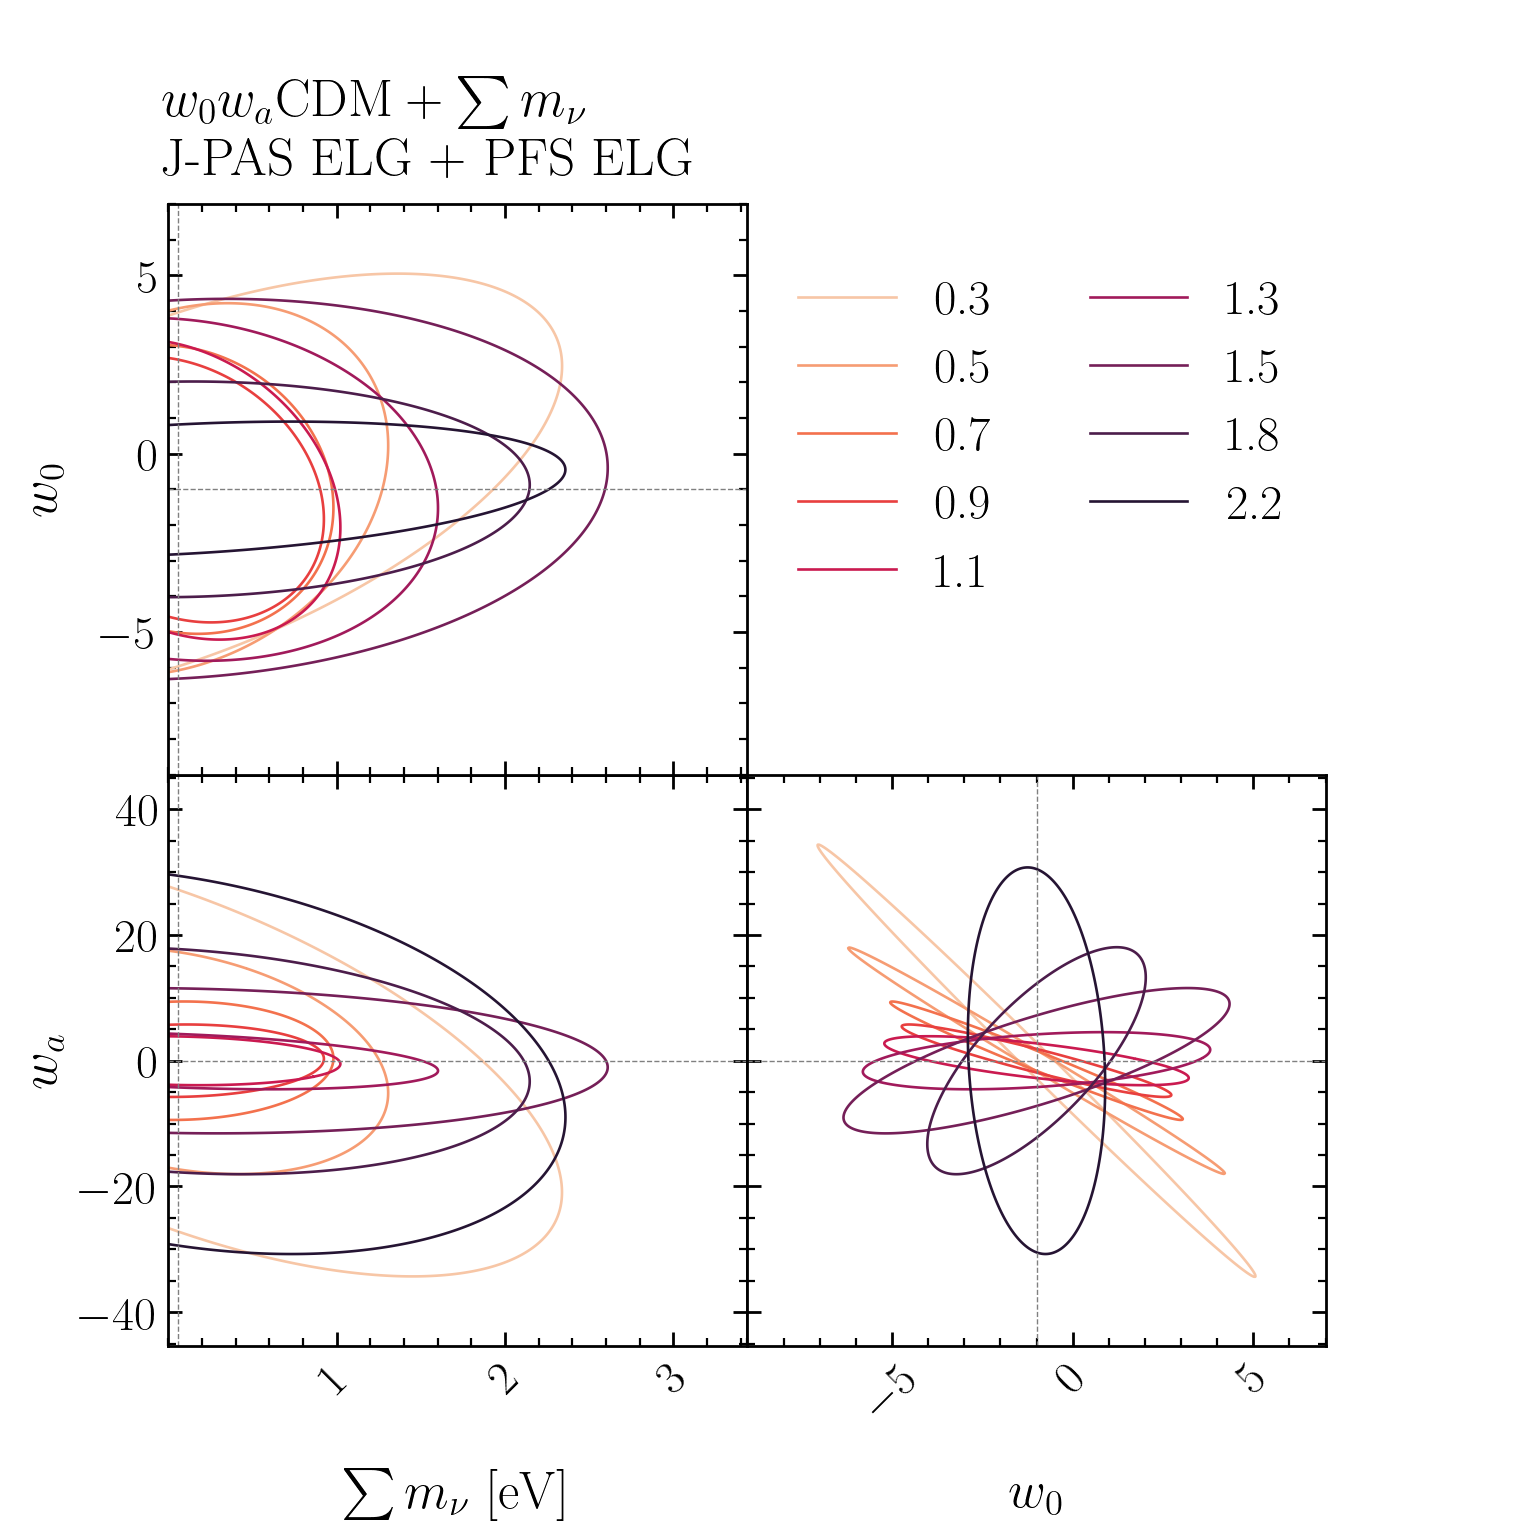

In [15]:
legend=[f'{z:.1f}' for z in settings.z]
ploter.fig.legend(axes[0][-1].get_lines()[:len(legend)],legend,loc=(0.51,0.6),ncol=2,frameon=False)
ploter.fig.text(0.1,0.73,r'$w_0w_a\mathrm{CDM}+\sum m_\nu$')
ploter.fig.text(0.1,0.7,'J-PAS ELG + PFS ELG')
ploter.fig

In [16]:
ploter.fig.savefig('../fig/jelg+pelg-z-w0wacdm-fixed.pdf',bbox_inches='tight')